In [16]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from math import ceil, floor
from matplotlib.colors import LogNorm

In [17]:
fits_filex='hlsp_frontier_model_abell2744_williams_v4_x-pixels-deflect.fits'
fits_filey='hlsp_frontier_model_abell2744_williams_v4_y-pixels-deflect.fits'
img_file='hlsp_frontier_model_abell2744_williams_v4_kappa.fits'
mag_file='hlsp_frontier_model_abell2744_williams_v4_z01-magnif.fits'
hdul = fits.open(fits_filex)
hdul1 = fits.open(fits_filey)
hdul_mag = fits.open(mag_file)
hdul_img = fits.open(img_file)


In [18]:
pixscale = 0.25
datax = hdul[0].data

datay = hdul1[0].data

data_img = hdul_img[0].data

#array_data = np.zeros((datax.shape[0],datax.shape[1]))
#array_data[100:160, 100:160]=datax[100:160, 100:160]

data_mag = hdul_mag[0].data
hdul.close()
hdul1.close()
hdul_img.close()

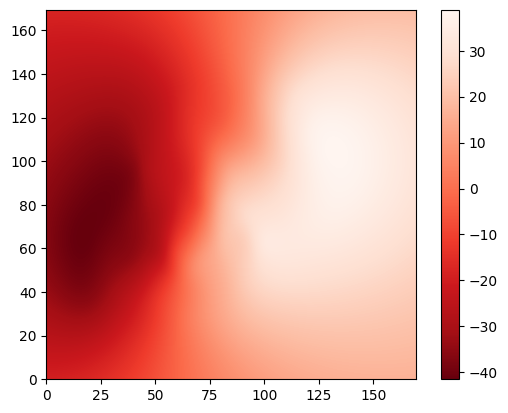

In [25]:
size = datax.shape[0]
datax = datax * pixscale
datay = datay * pixscale
plt.imshow(datax, cmap='Reds_r',extent=[0, size*pixscale, size*pixscale,0 ])
plt.gca().invert_yaxis()
datax = datax / pixscale
datay = datay / pixscale
plt.colorbar()

32


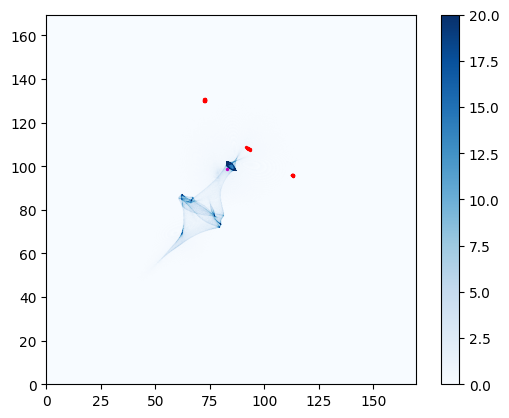

In [44]:
size = datax.shape[0]

array_test = np.zeros((size,size))
img_coord_in_src_coord = [[[] for _ in range(678)] for _ in range(678)]
for i in range(0,678):
    for j in range(0,678):
        ycoord = i-datay[i,j]
        xcoord = j-datax[i,j]
        ydec = ycoord%1
        xdec = xcoord%1
        xfloor = floor(xcoord)
        yfloor = floor(ycoord)
        #array_test[ceil(ycoord),ceil(xcoord)] += data_img[i,j]*ydec*xdec
        #array_test[ceil(ycoord),floor(xcoord)] += data_img[i,j]*ydec*(1-xdec)
        #array_test[floor(ycoord),ceil(xcoord)] += data_img[i,j]*(1-ydec)*xdec
        array_test[yfloor,xfloor] += data_img[i,j]*(1-ydec)*(1-xdec)
        #img_coord_in_src_coord[floor(ycoord)][floor(xcoord)].append([i,j])


#gaussian circle
'''mean = [260, 330] #(x,y)
cov = [[40, 0], [0, 40]]

# Generate a grid of (x, y) coordinates
x, y = np.meshgrid(np.linspace(0, size, size), np.linspace(0, size, size))

# Generate a 2D Gaussian distribution over the grid
d = np.dstack([x, y])
gaussian_circle = np.exp(-0.5 * (np.einsum('...k,kl,...l->...', d - mean, np.linalg.inv(cov), d - mean)))
circle_coords = np.argwhere(gaussian_circle > 0.5)

# radius
from scipy.ndimage import distance_transform_edt as distance
radius = max(circle_coords[:,1])-mean[0]
print(f'Radius: {radius}')'''



'''#specific method for perfect circle
for i in range(size):
    for j in range(size):
        ycoord = i-datay[i,j]
        xcoord = j-datax[i,j]
        if ycoord<0 or ycoord>677 or xcoord<0 or xcoord>677:
            continue
        dist = np.sqrt((ycoord-center[1])**2+(xcoord-center[0])**2)
        if dist <= radius:
            scatterx.append(j)
            scattery.append(i)
            n+=1'''
            
# point source            
coord = (332.2,394.4)
coord_x_r, coord_y_r = coord[0] % 1, coord[1] % 1
y_round, x_round = round(coord[1]), round(coord[0])

# Pre-calculate possible matching rounded values for efficiency
y_possible_rounds = {y_round, y_round - 1} if coord_y_r == 0.5 else {y_round}
x_possible_rounds = {x_round, x_round - 1} if coord_x_r == 0.5 else {x_round}

coordinates = []
n = 0

# Iterate over a pre-defined range, assuming alpha_y_2d and alpha_x_2d are indexed appropriately
for i in range(size):
    for j in range(size):
        ycoord, xcoord = i - datay[i, j], j - datax[i, j]
        if round(ycoord) in y_possible_rounds and round(xcoord) in x_possible_rounds:
            coordinates.append((j, i))  # (x, y)
            n += 1

plt.scatter([i[0] * pixscale for i in coordinates], [i[1] * pixscale for i in coordinates], c='r', s=2)
plt.scatter(coord[0]* pixscale, coord[1]* pixscale, c='m', s=2)
print(n)


'''for (i,j) in circle_coords:
    
    for point in img_coord_in_src_coord[i][j]:
        n+=1
        scatterx.append(point[1])
        scattery.append(point[0])'''



plt.imshow(array_test, cmap='Blues', vmax=20, extent=[0, size*pixscale, size*pixscale,0 ])
plt.gca().invert_yaxis()
plt.colorbar()



Number of pixels: [9, 10, 13]


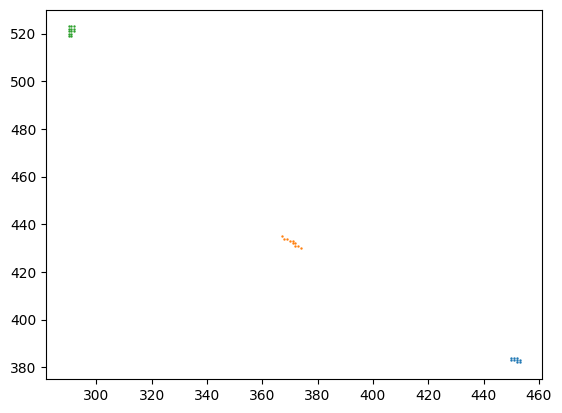

In [45]:
#Clustering
from sklearn.cluster import DBSCAN

coordinates = np.array(coordinates) #data in pixel

# Apply DBSCAN clustering
# eps and min_samples need to be chosen based on your specific data
dbscan = DBSCAN(eps=6, min_samples=1).fit(coordinates)

# Extract labels
labels = dbscan.labels_

# Separate coordinates into arrays for each image
images = {}
for label in set(labels):
    if label != -1:  # Ignore noise points
        images[f"Image_{label}"] = coordinates[labels == label]

# images now contains separate arrays for each detected image
# convert the dictionary images to list
images = list(images.values())

for i in range(0, len(images)):
    plt.scatter(images[i][:,0], images[i][:,1], s=0.5)
print(f'Number of pixels: {[np.sum(len(images[i])) for i in range(0, len(images))]}')

In [46]:
datax = np.array(datax, dtype=np.float64)
datay = np.array(datay, dtype=np.float64)
# interpolate the deflected angle given the image pos
def def_angle_test_interpolate(x,y, alpha_x= datax, alpha_y = datay):  #(x,y) is img_guess
    dx = x - floor(x)
    dy = y - floor(y)
    top_left = np.array([alpha_x[ceil(y), floor(x)], alpha_y[ceil(y), floor(x)]]) #to match (y,x) of alpha grid
    top_right = np.array([alpha_x[ceil(y), ceil(x)], alpha_y[ceil(y), ceil(x)]])
    bottom_left = np.array([alpha_x[floor(y), floor(x)], alpha_y[floor(y), floor(x)]])
    bottom_right = np.array([alpha_x[floor(y), ceil(x)], alpha_y[floor(y), ceil(x)]])
    top = top_left * (1 - dx) + top_right * dx
    bottom = bottom_left * (1 - dx) + bottom_right * dx
    alpha = top * dy + bottom *(1 - dy)
    src_guess = np.array([x-alpha[0], y-alpha[1]])
    return src_guess, alpha
                                             
def diff_interpolate (img_guess):
    src_guess = def_angle_test_interpolate(img_guess[0],img_guess[1])[0]
    return np.sqrt((src_guess[0]-coord[0])**2 + (src_guess[1]-coord[1])**2)
alpha = def_angle_test_interpolate(291.40020377, 522.72600263)[1]
print(f"{alpha[0]:.8f}, {alpha[1]:.8f}")


-40.79979179, 128.32599538


112.5 113.25 95.5 96.0 [112.98487093  95.97231714] 6.763750623867338e-08
91.75 93.5 107.5 108.75 [ 92.8899807  108.09972191] 6.503620990874408e-08
72.5 73.0 129.75 130.75 [ 72.85005321 130.68149316] 5.6047609984989956e-08


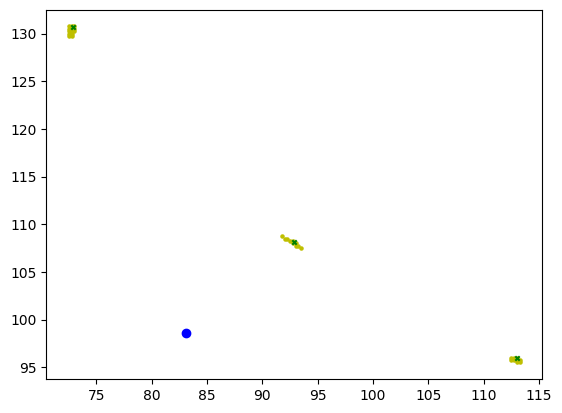

In [47]:
import scipy.optimize._minimize as minimize
# minimum distance between the source position and the guess source positions deflected by mutiple images
# expect partition of the images and search for 1 sol for 1 image
plt.scatter(coord[0]* pixscale, coord[1]* pixscale, c='b')
plt.scatter([i[0]* pixscale for i in coordinates], [i[1]* pixscale for i in coordinates], c='y', s=5)
# find maximum x and y coordinates of the image[i]
for i in range(len(images)):
    x_max, x_min = np.max(images[i][:,0]), np.min(images[i][:,0])
    y_max, y_min = np.max(images[i][:,1]), np.min(images[i][:,1])
    img_guess = np.random.uniform(x_min, x_max), np.random.uniform(y_min, y_max)
    pos = minimize.minimize(diff_interpolate, img_guess, bounds =[(x_min-2, x_max+2), (y_min-2, y_max+2)], method='L-BFGS-B', tol=1e-7) # the 1 is for wider boundary
    print(x_min* pixscale, x_max* pixscale, y_min* pixscale, y_max* pixscale, pos.x* pixscale, diff_interpolate(pos.x))
    plt.scatter(pos.x[0]* pixscale, pos.x[1]* pixscale, c='g', s=10, marker='x')

#fig show in arcsec

In [48]:
#magnification
image_position = np.array([72.85005321/pixscale, 130.68149316/ pixscale])
def calculate_magnification(theta, h=1e-9):
    """
    Calculate the magnification at a given image position theta.
    
    :param theta: Image position (2D numpy array)
    :param h: Step size for numerical differentiation
    :return: Magnification
    """
    # Compute partial derivatives

    def partial_derivative(func, var, point): 
        args = point[:]
        def wraps(x):
            args[var] = x
            return func(args)
        
        #print(wraps(point[var]+h), wraps(point[var]-h))
       
        return lambda x: (wraps(x+h) - wraps(x-h))/(2*h) # central difference diff fct

    def alpha(t):
        alpha = def_angle_test_interpolate(t[0], t[1])[1] #problem: tuple always rounded to few decimal places
        a = float(f"{alpha[0]:.12f}")
        b = float(f"{alpha[1]:.12f}")
        return np.array([a, b])
   
    dalpha1_dtheta1 = partial_derivative(lambda t: alpha(t)[0], 0, theta)(theta[0])
    dalpha1_dtheta2 = partial_derivative(lambda t: alpha(t)[0], 1, theta)(theta[1])
    dalpha2_dtheta1 = partial_derivative(lambda t: alpha(t)[1], 0, theta)(theta[0])
    dalpha2_dtheta2 = partial_derivative(lambda t: alpha(t)[1], 1, theta)(theta[1])
    print(dalpha1_dtheta1, dalpha1_dtheta2, dalpha2_dtheta1, dalpha2_dtheta2)
    # Construct the magnification tensor
    A = np.array([
        [1 - dalpha1_dtheta1, -dalpha1_dtheta2],
        [-dalpha2_dtheta1, 1 - dalpha2_dtheta2]
    ])
    
    # Calculate magnification
    magnification = 1 / np.linalg.det(A)
    
    return magnification

# Example usage

mag = calculate_magnification(image_position)
print(f"Interpolation magnification at {image_position* pixscale}: {mag}")





0.5874980502085236 0.021998403099132702 0.023007373783912044 0.7665050816285657
Interpolation magnification at [ 72.85005321 130.68149316]: 10.437216718816128


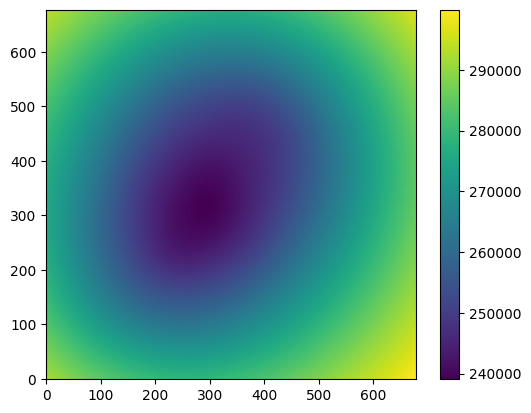

In [50]:
# psi map
psi = 'hlsp_frontier_model_abell2744_williams_v4_psi.fits'
hdul_psi = fits.open(psi)
data_psi = hdul_psi[0].data
plt.imshow(data_psi, cmap='viridis')
plt.gca().invert_yaxis()
plt.colorbar()

In [55]:
theta = image_position*pixscale
beta = np.array(coord) * pixscale
def psi_interpolate(x,y, psi = data_psi):  #(x,y) is img_guess
    x = x/pixscale
    y = y/pixscale
    dx = x - floor(x)
    dy = y - floor(y)
    top_left = np.array(psi[ceil(y), floor(x)]) #to match (y,x) of alpha grid
    top_right = np.array(psi[ceil(y), ceil(x)])
    bottom_left = np.array(psi[floor(y), floor(x)])
    bottom_right = np.array(psi[floor(y), ceil(x)])
    top = top_left * (1 - dx) + top_right * dx
    bottom = bottom_left * (1 - dx) + bottom_right * dx
    psi = top * dy + bottom *(1 - dy)
    return psi

def fermat_potential(theta, beta):
    return 0.5 * (np.linalg.norm(theta - beta)**2) - psi_interpolate(theta[0], theta[1])

print(f"Interpolation Fermat potential at {theta}: {fermat_potential(theta, beta)}")

# time delay by diff of fermat potentials and scale it by time-delay distance

theta2 = np.array([92.8899807,  108.09972191])
dt = (fermat_potential(theta, beta) - fermat_potential(theta2, beta))
print(dt)

Interpolation Fermat potential at [ 72.85005321 130.68149316]: -253963.63877022496
-7741.132588545763


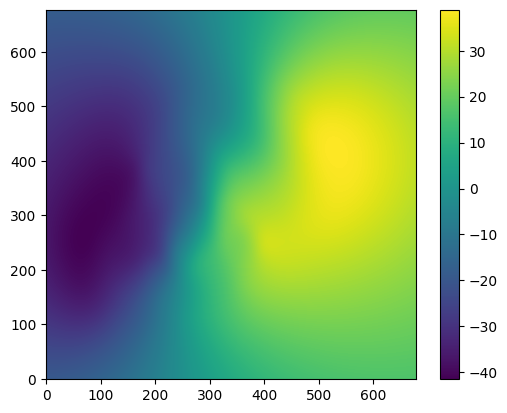

In [13]:
fits_arcsec = 'hlsp_frontier_model_abell2744_williams_v4_x-arcsec-deflect.fits'
hdul_arcsec = fits.open(fits_arcsec)
data_arcsec = hdul_arcsec[0].data
plt.imshow(data_arcsec, cmap='viridis')
plt.gca().invert_yaxis()
plt.colorbar()